In [4]:
import torch 
import pyro
import matplotlib.pyplot as plt
from IPython.display import clear_output
import matplotlib

We generate $x_1,..., x_N$

In [11]:
from targets.conditional_density_estimation_target import Wave
target = Wave()

N_simulations = 500
D_theta = target.sample_prior(N_simulations)
D_x = target.simulate(D_theta)

mu_theta = torch.zeros(1)
sigma_theta = torch.eye(1)
theta_prior_distribution = torch.distributions.MultivariateNormal(mu_theta, sigma_theta)
theta0 = theta_prior_distribution.sample()
theta0 = 0*torch.ones(1)

N_observations = 1
x0 = target.simulate(theta0.unsqueeze(0).repeat(N_observations,1))
x = torch.cat([D_theta, D_x], dim=1)
print(x.shape)

torch.Size([500, 2])


We suppose that the data is generated according to the following sampling scheme:
- $w_1,...,w_K,... \sim GEM(\alpha)$ is a prior over mean and covariances
- $(\mu_1, \Sigma_1),..., (\mu_K,\Sigma_K),... \sim NIW(\mu_0, \lambda, \Psi, \nu)$ 
- $z_1,..., z_N \sim \sum_{k=1}^\infty w_k \delta_k$
- $x_i|z_i \sim N(mu_{z_i}, \Sigma_{z_i})$

In [12]:
#prior_parameters
d=2
nu = 3
lbda = 0.01
mu = torch.mean(x, dim=0).float()
psi = torch.eye(d)/50
alpha = torch.tensor(10.)
truncation = 5

In [13]:
def plot_assignation(x,z):
    plt.scatter(x[:,0].numpy(), x[:,1].numpy(), c=z, cmap = matplotlib.cm.get_cmap('plasma'), alpha = .5)

def compute_posterior_parameters(x): 
    empirical_mean = torch.mean(x, dim =0)
    mu_N = (lbda*mu + x.shape[0]*empirical_mean)/(lbda + x.shape[0])
    S = torch.cov(x.T)*(x.shape[0]-1) if x.shape[0]>=2 else torch.zeros(d)
    temp = (empirical_mean-mu).unsqueeze(-1)
    psi_N = psi + S + (lbda*x.shape[0]*temp@temp.T)/(lbda + x.shape[0])
    return nu + x.shape[0], lbda + x.shape[0], mu_N, psi_N
    
def compute_probability(x,z,i):
    z_i = torch.cat([z[:i], z[i+1:]], dim =0)
    list_weight = []
    list_evaluated_prob=[]
    for c in torch.unique(z_i):
        extracted = x[z==c]
        nu_n_c, lbda_n_c, mu_n_c, psi_n_c = compute_posterior_parameters(extracted)
        list_weight.append(extracted.shape[0]/(x.shape[0]-1+alpha))
        list_evaluated_prob.append(torch.exp(pyro.distributions.MultivariateStudentT(nu_n_c-d+1,mu_n_c,torch.cholesky(psi_n_c*(lbda_n_c+1)/(lbda_n_c*(nu_n_c - d + 1)))).log_prob(x[i,:])))
    list_evaluated_prob.append(torch.exp(pyro.distributions.MultivariateStudentT(nu-d+1,mu,torch.cholesky(psi*(lbda+1)/(lbda*(nu - d + 1)))).log_prob(x[i,:])))                               
    list_weight.append(alpha/(x.shape[0]-1+alpha))
    probs = torch.tensor(list_weight)*torch.tensor(list_evaluated_prob)
    return probs    

In [14]:
def prob(new_x,x,z):
    list_weight = []
    list_evaluated_prob=[]
    for c in torch.unique(z):
        extracted = x[z==c]
        nu_n_c, lbda_n_c, mu_n_c, psi_n_c = compute_posterior_parameters(extracted)
        list_weight.append(extracted.shape[0]/(x.shape[0]))
        list_evaluated_prob.append(torch.exp(pyro.distributions.MultivariateStudentT(nu_n_c-d+1,mu_n_c,torch.cholesky(psi_n_c*(lbda_n_c+1)/(lbda_n_c*(nu_n_c - d + 1)))).log_prob(new_x)).unsqueeze(-1))
        temp  = torch.exp(pyro.distributions.MultivariateStudentT(nu_n_c-d+1,mu_n_c,torch.cholesky(psi_n_c*(lbda_n_c+1)/(lbda_n_c*(nu_n_c - d + 1)))).log_prob(new_x))
    probs = torch.sum(torch.tensor(list_weight).unsqueeze(0)*torch.cat(list_evaluated_prob, dim=1), dim= -1)
    return probs  

torch.Size([26])


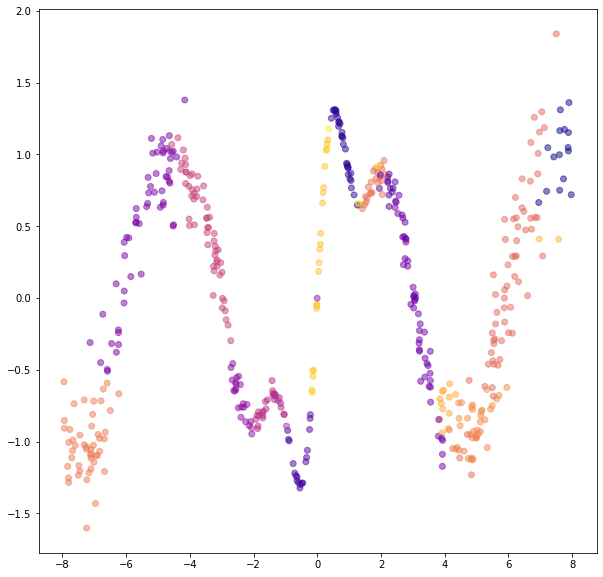

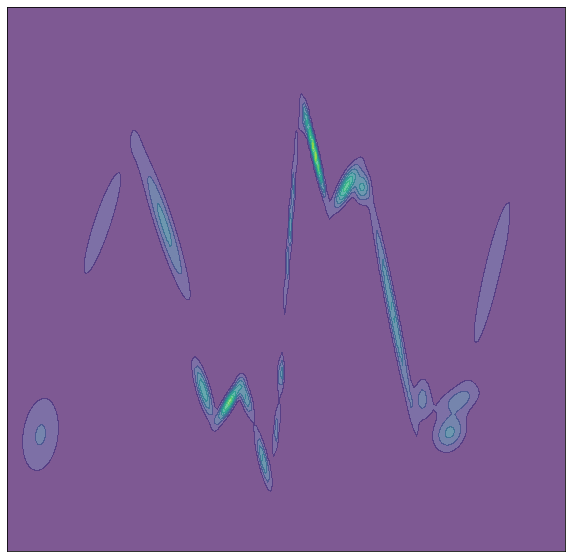

In [ ]:
z =torch.zeros(x.shape[0])
while True:
    clear_output(wait=True)
    for i in range(x.shape[0]):
        probs = compute_probability(x,z,i)
        temp = torch.cat([z[:i], z[i+1:]], dim =0)
        list_z_i = torch.cat([torch.unique(temp),(torch.max(torch.unique(temp)) + 1).unsqueeze(-1)])
        z[i] = list_z_i[torch.distributions.Categorical(probs/torch.sum(probs)).sample()]
    print(torch.unique(z).shape)

    plt.figure(figsize = (10,10))
    plot_assignation(x,z)
    plt.show()
    plot_2d_function(lambda samples: prob(samples,x,z),x_min =torch.min(x[:,0])-0.25,x_max = torch.max(x[:,0])+0.25, y_min = torch.min(x[:,1])-0.25, y_max = torch.max(x[:,1])+0.25, levels = 10)
    plt.show()

In [16]:
def plot_2d_function(f, x_min = -10,x_max = 10, y_min = -10, y_max = 10, delta = 200, levels = 2 , alpha = 0.7, new_figure = True):
    if new_figure :
        plt.figure(figsize = (10,10))
        plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    tt_x = torch.linspace(x_min, x_max, delta)
    tt_y = torch.linspace(y_min,y_max, delta)
    mesh = torch.cartesian_prod(tt_x, tt_y)
    with torch.no_grad():
        plt.contourf(tt_x,tt_y,f(mesh).numpy().reshape(delta,delta).T, levels = levels, cmap = matplotlib.cm.get_cmap('viridis'), alpha = alpha)